# АВС-анализ ассортимента онлайн-магазина товаров для праздника


Вы работаете в крупном онлайн-магазине, который реализует товары «всё для праздников». Вам необходимо провести ABC-анализ и выявить наиболее важные товары на основе объемов продаж и популярности. Эта информация составит план закупок на весь следующий год.

**ABC-анализ** позволяет определить наиболее важные ресурсы компании на основе объемов продаж и прибыли.

В основе ABC-анализа лежит __«Принцип Парето»: 20% ресурсов приносят 80% прибыли__. Именно этот вид анализа позволяет выделить те самые  группы товаров, ресурсов, клиентов, поставщиков и т. п., которые и приносят компании основную прибыль.

__Задача анализа разделить товары на группы по принципу:__

- А — наиболее ценные, 20% — ассортимента; 80% — продаж
- В — промежуточные, 30% — ассортимента; 15% — продаж
- С — наименее ценные, 50% — ассортимента; 5% — продаж

## Что нужно сделать?

1. Выгрузить данные по продуктам из PostgreSQL
2. Посчитать, какой доход принес каждый продукт и сколько единиц каждого продукта было продано
3-4. Найти нарастающий итог в процентах по продажам и распределить товары в группы A, B и C по продажам
5. Найти нарастающий итог в процентах по количеству товарных единиц и распределить товары в группы A, B и C по популярности
6. Объединить группы, визуализировать и проанализировать результат
7. Выгрузить данные для отправки в отдел закупок

## Задание 1

Сохрани все данные из таблицы `products` из PostgreSQL в дата-фрейм `products` и подготовь данные к анализу.

In [1]:
from postgresql_secret_hw import pg_secret

In [2]:
pg_secret

{'db_host': '178.154.254.133',
 'db_name': 'skyeng',
 'db_password': 'readonlyuser',
 'db_port': '5432',
 'db_user': 'readonlyuser'}

In [3]:
import psycopg2

connection = psycopg2.connect(
                             database=pg_secret['db_name'],
                             user=pg_secret['db_user'],
                             password=pg_secret['db_password'],
                             host=pg_secret['db_host'],
                             port=pg_secret['db_port'],
                             )

In [4]:
cursor = connection.cursor()

In [5]:
query = "SELECT * FROM products"

cursor.execute(query)

In [6]:
import pandas as pd

products = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

products.head()

,invoice_id,stock_code,description,quantity,price
0,513956,22428,ENAMEL FIRE BUCKET CREAM,2,6.95
1,513956,22426,ENAMEL WASH BOWL CREAM,2,3.75
2,513958,22386,JUMBO BAG PINK WITH WHITE SPOTS,50,1.95
3,513959,22444,GROW YOUR OWN PLANT IN A CAN,48,1.25
4,513959,22421,LIPSTICK PEN FUSCHIA,12,0.42


## Задание 2

Посчитай, какой доход принес каждый продукт и сколько единиц каждого продукта было продано.

In [7]:
products['total'] = products.quantity * products.price

In [8]:
# считаем общий доход по каждому товару

products_total_sum = products.groupby(products.stock_code)['total'].sum().reset_index()

products_total_sum.rename(columns={'total': 'total_sum'}, inplace=True) # переименовываем столбец с суммарной выручкой

products_total_sum.head()

,stock_code,total_sum
0,10002,6638.27
1,10080,124.61
2,10109,1.68
3,10120,136.08
4,10123C,226.76


In [9]:
# считаем общее количество проданных единиц по каждому товару

products_total_num = products.groupby(products.stock_code)['quantity'].sum().reset_index()

products_total_num.rename(columns={'quantity': 'total_num'}, inplace=True) # переименовываем столбец с суммарным количеством

products_total_num.head()

,stock_code,total_num
0,10002,8479
1,10080,303
2,10109,4
3,10120,648
4,10123C,628


In [10]:
# объединяем общие данные в одну таблицу

products_total = pd.merge(products_total_sum,
                          products_total_num,
                          on='stock_code',
                          how='inner'
                         )

products_total.head()

,stock_code,total_sum,total_num
0,10002,6638.27,8479
1,10080,124.61,303
2,10109,1.68,4
3,10120,136.08,648
4,10123C,226.76,628


## Задание 3

Найди нарастающий итог по процентам и пометь товары метками `'A'`, `'B'`, `'C'` в зависимости от нарастающего итога.

In [11]:
# сортируем дата-фрейм по убыванию

products_total = products_total.sort_values(by='total_sum', ascending=False)

products_total.head()

,stock_code,total_sum,total_num
1609,22423,277656.25,24139
4080,85123A,247203.36,91814
2726,23843,168469.60,80995
4058,85099B,167920.64,93436
4625,M,151777.67,9391


In [12]:
# находим процент дохода для каждого товара

grand_total_sum = products_total.total_sum.sum()

products_total['rev_share'] = products_total.total_sum / grand_total_sum * 100

products_total.head()

,stock_code,total_sum,total_num,rev_share
1609,22423,277656.25,24139,1.598039586546708864360299196
4080,85123A,247203.36,91814,1.422769180262851018882701945
2726,23843,168469.60,80995,0.9696201325548746829766441829
4058,85099B,167920.64,93436,0.9664606149447698094210183692
4625,M,151777.67,9391,0.8735503883446629333967892041


In [13]:
# находим кумулятивную сумму по процентам

products_total['rev_share_cum'] = products_total.rev_share.cumsum()

products_total

,stock_code,total_sum,total_num,rev_share,rev_share_cum
1609,22423,277656.25,24139,1.598039586546708864360299196,1.598039586546708864360299196
4080,85123A,247203.36,91814,1.422769180262851018882701945,3.020808766809559883243001141
2726,23843,168469.60,80995,0.9696201325548746829766441829,3.990428899364434566219645324
4058,85099B,167920.64,93436,0.9664606149447698094210183692,4.956889514309204375640663693
4625,M,151777.67,9391,0.8735503883446629333967892041,5.830439902653867309037452897
...,...,...,...,...,...
4630,TEST002,1.00,1,0.000005755460525548079196345478252,99.99999073370855386759249359
247,20721,0.85,1,0.000004892141446715867316893656514,99.99999562585000058345981048
3419,84205C,0.38,2,0.000002187074999708270094611281736,99.99999781292500029172990509
2847,35930,0.38,1,0.000002187074999708270094611281736,99.99999999999999999999999970


In [14]:
def revenue(x):
    if x <= 80:
        return 'A'
    elif x <= 95:
        return 'B'
    else:
        return 'C'

In [15]:
# создаем новый столбец revenue с помощью функции

products_total['revenue'] = products_total['rev_share_cum'].apply(revenue)

products_total

,stock_code,total_sum,total_num,rev_share,rev_share_cum,revenue
1609,22423,277656.25,24139,1.598039586546708864360299196,1.598039586546708864360299196,A
4080,85123A,247203.36,91814,1.422769180262851018882701945,3.020808766809559883243001141,A
2726,23843,168469.60,80995,0.9696201325548746829766441829,3.990428899364434566219645324,A
4058,85099B,167920.64,93436,0.9664606149447698094210183692,4.956889514309204375640663693,A
4625,M,151777.67,9391,0.8735503883446629333967892041,5.830439902653867309037452897,A
...,...,...,...,...,...,...
4630,TEST002,1.00,1,0.000005755460525548079196345478252,99.99999073370855386759249359,C
247,20721,0.85,1,0.000004892141446715867316893656514,99.99999562585000058345981048,C
3419,84205C,0.38,2,0.000002187074999708270094611281736,99.99999781292500029172990509,C
2847,35930,0.38,1,0.000002187074999708270094611281736,99.99999999999999999999999970,C


In [16]:
products_total.loc[products_total['revenue'] == 'B']

,stock_code,total_sum,total_num,rev_share,rev_share_cum,revenue
2913,37447,3876.97,2693,0.02231374779373413660185552882,80.01584248064262364279586066,B
1726,22548,3873.10,3315,0.02229147416150026553536567182,80.03813395480412390833122633,B
2690,23557,3867.85,347,0.02226125799374113811958485806,80.06039521279786504645081119,B
3246,72802B,3862.88,1478,0.02223265335492916416597902103,80.08262786615279421061679021,B
1709,22530,3862.44,9630,0.02223012095229792301113262902,80.10485798710509213362792284,B
...,...,...,...,...,...,...
1465,22268,1075.55,2345,0.006190285568253236579629379134,94.97056572594191960464820784,B
2648,23515,1075.38,558,0.006189307139963893406166000403,94.97675503308188349805437384,B
3559,84562A,1073.25,143,0.006177048009044475997477784534,94.98293208109092797405185162,B
2646,23513,1072.96,556,0.006175378925492067054510844345,94.98910746001642004110636246,B


## Задание 4

Найди нарастающий итог по количеству товарных единиц и пометь товары метками `'A'`, `'B'`, `'C'`, отмечая тем самым популярность товара.

In [17]:
# сортируем дата-фрейм по убыванию

products_total = products_total.sort_values(by='total_num', ascending=False)

products_total.head()

,stock_code,total_sum,total_num,rev_share,rev_share_cum,revenue
3410,84077,24098.03,105185,0.1386952604084733789159092253,34.44687568206703681280322916,A
4058,85099B,167920.64,93436,0.9664606149447698094210183692,4.956889514309204375640663693,A
4080,85123A,247203.36,91814,1.422769180262851018882701945,3.020808766809559883243001141,A
601,21212,43390.03,89850,0.2497296048673469227718061917,18.46732230091167789703299823,A
2726,23843,168469.60,80995,0.9696201325548746829766441829,3.990428899364434566219645324,A


In [18]:
# находим процент от общего количества для каждого товара

grand_total_num = products_total.total_num.sum()

products_total['quan_share'] = products_total.total_num / grand_total_num * 100

products_total.head()

,stock_code,total_sum,total_num,rev_share,rev_share_cum,revenue,quan_share
3410,84077,24098.03,105185,0.1386952604084733789159092253,34.44687568206703681280322916,A,0.999031
4058,85099B,167920.64,93436,0.9664606149447698094210183692,4.956889514309204375640663693,A,0.887441
4080,85123A,247203.36,91814,1.422769180262851018882701945,3.020808766809559883243001141,A,0.872035
601,21212,43390.03,89850,0.2497296048673469227718061917,18.46732230091167789703299823,A,0.853381
2726,23843,168469.60,80995,0.9696201325548746829766441829,3.990428899364434566219645324,A,0.769278


In [19]:
# находим кумулятивную сумму по процентам

products_total['quan_share_cum'] = products_total.quan_share.cumsum()

products_total

,stock_code,total_sum,total_num,rev_share,rev_share_cum,revenue,quan_share,quan_share_cum
3410,84077,24098.03,105185,0.1386952604084733789159092253,34.44687568206703681280322916,A,0.999031,0.999031
4058,85099B,167920.64,93436,0.9664606149447698094210183692,4.956889514309204375640663693,A,0.887441,1.886471
4080,85123A,247203.36,91814,1.422769180262851018882701945,3.020808766809559883243001141,A,0.872035,2.758506
601,21212,43390.03,89850,0.2497296048673469227718061917,18.46732230091167789703299823,A,0.853381,3.611888
2726,23843,168469.60,80995,0.9696201325548746829766441829,3.990428899364434566219645324,A,0.769278,4.381166
...,...,...,...,...,...,...,...,...
2907,37438,3.75,1,0.00002158297697080529698629554344,99.99938830965534475014301214,C,0.000009,99.999962
4279,90025B,3.75,1,0.00002158297697080529698629554344,99.99934514370140313954903954,C,0.000009,99.999972
4241,90004A,3.75,1,0.00002158297697080529698629554344,99.99932356072443233425205324,C,0.000009,99.999981
2874,35974,3.75,1,0.00002158297697080529698629554344,99.99928039477049072365808064,C,0.000009,99.999991


In [20]:
def quantity(x):
    if x <= 80:
        return 'A'
    elif x <= 95:
        return 'B'
    else:
        return 'C'

In [21]:
# создаем новый столбец popularity с помощью функции

products_total['popularity'] = products_total['quan_share_cum'].apply(quantity)

products_total

,stock_code,total_sum,total_num,rev_share,rev_share_cum,revenue,quan_share,quan_share_cum,popularity
3410,84077,24098.03,105185,0.1386952604084733789159092253,34.44687568206703681280322916,A,0.999031,0.999031,A
4058,85099B,167920.64,93436,0.9664606149447698094210183692,4.956889514309204375640663693,A,0.887441,1.886471,A
4080,85123A,247203.36,91814,1.422769180262851018882701945,3.020808766809559883243001141,A,0.872035,2.758506,A
601,21212,43390.03,89850,0.2497296048673469227718061917,18.46732230091167789703299823,A,0.853381,3.611888,A
2726,23843,168469.60,80995,0.9696201325548746829766441829,3.990428899364434566219645324,A,0.769278,4.381166,A
...,...,...,...,...,...,...,...,...,...
2907,37438,3.75,1,0.00002158297697080529698629554344,99.99938830965534475014301214,C,0.000009,99.999962,C
4279,90025B,3.75,1,0.00002158297697080529698629554344,99.99934514370140313954903954,C,0.000009,99.999972,C
4241,90004A,3.75,1,0.00002158297697080529698629554344,99.99932356072443233425205324,C,0.000009,99.999981,C
2874,35974,3.75,1,0.00002158297697080529698629554344,99.99928039477049072365808064,C,0.000009,99.999991,C


## Задание 5

Объедини группы и проанализируй результат.

In [22]:
# объединяем группы и подсчитываем значения

products_total['group'] = products_total['revenue'] + products_total['popularity']

products_total['group'].value_counts()

CC    2041
AA     685
BB     577
BC     377
CB     303
BA     270
AB     248
CA      72
AC      58
Name: group, dtype: int64

__Вывод__ 

Товары в группе CC непопулярны и приносят мало дохода. При составлении плана закупок нужно сосредоточиться на группе AA, в которой собраны товары, находящиеся в топе по выручке и популярности 

In [23]:
abc_description = products_total.copy()

# заведем словари с текстовыми расшифровками буквенных категорий

revenue_dict = {"A": "A (наиболее доходные)", 'B': "B (средне доходные)", 'C': "C (наименее доходные)"}
popularity_dict = {'A': "A (наиболее популярные)",'B': "B (средне популярные)", 'C': "C (наименее популярные)"}

# заменяем буквенные категории на их значения из словарей

abc_description['revenue'] = abc_description['revenue'].map(revenue_dict)
abc_description['popularity'] = abc_description['popularity'].map(popularity_dict)

In [24]:
abc = abc_description.groupby(['revenue', 'popularity'], as_index=False)['stock_code'].count()

abc

,revenue,popularity,stock_code
0,A (наиболее доходные),A (наиболее популярные),685
1,A (наиболее доходные),B (средне популярные),248
2,A (наиболее доходные),C (наименее популярные),58
3,B (средне доходные),A (наиболее популярные),270
4,B (средне доходные),B (средне популярные),577
5,B (средне доходные),C (наименее популярные),377
6,C (наименее доходные),A (наиболее популярные),72
7,C (наименее доходные),B (средне популярные),303
8,C (наименее доходные),C (наименее популярные),2041


In [25]:
# сделаем сводную таблицу

abc_pivot = abc.pivot(index="revenue", 
                      columns="popularity", 
                      values="stock_code"
                     ).reset_index()

abc_pivot = abc_pivot.set_index('revenue')

abc_pivot

popularity,A (наиболее популярные),B (средне популярные),C (наименее популярные)
revenue,,,
A (наиболее доходные),685,248,58
B (средне доходные),270,577,377
C (наименее доходные),72,303,2041


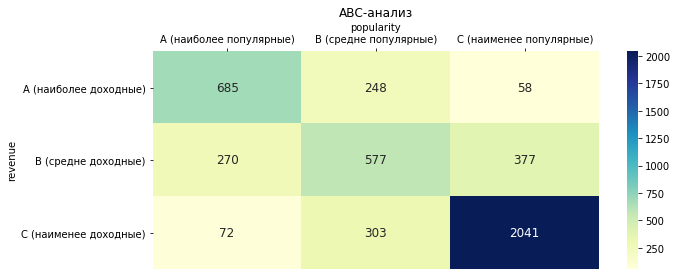

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# построим heatmap

f, ax = plt.subplots(figsize=(10, 4)) # создадим фигуру и оси
                     
sns.heatmap(abc_pivot, 
            annot=True,
            cmap="YlGnBu",
            fmt='g',
            annot_kws={'size':12}) # вручную зададим размер шрифта в ячейках
            
plt.title("ABC-анализ")            

plt.yticks(rotation=0) # вручную зададим угол подписей
ax.xaxis.set_ticks_position('top') # укажем, что подписи колонок должны быть наверху
ax.xaxis.set_label_position('top') # укажем, что подпись оси x должна быть наверху
            
plt.ylabel("revenue")
plt.xlabel("popularity")

plt.show()

## Задание 6

Выгрузи данные по товарам с меткой по ABC-анализу в `csv` для отправки в отдел закупок.

In [27]:
products_table = products[['stock_code', 'description']].drop_duplicates()

# в данных для некоторых stock_code существует до 4х разных description 
# также есть значения stock_code BANK CHARGES и ADJUST, которые не являются товарами

descr_count = products_table.groupby('stock_code')['description'].count().reset_index()

descr_count.loc[descr_count['description'] > 1].sort_values(by='description', ascending=False)

,stock_code,description
1212,21955,4
1541,22345,4
1576,22384,4
219,20685,4
1542,22346,4
...,...,...
1593,22407,2
1594,22408,2
1595,22409,2
1596,22410,2


In [28]:
# по сути description не отличаются, можно оставить один из вариантов

products_table.loc[products_table['stock_code'].isin(['21955', '22345', '22384', '20685', '22346'])]\
    .sort_values(by='stock_code')

,stock_code,description
77860,20685,DOORMAT RED RETROSPOT
435,20685,DOOR MAT RED SPOT
1047,20685,DOORMAT RED SPOT
589385,20685,RED SPOTTY COIR DOORMAT
4239,21955,DOORMAT UNION JACK GUNS AND ROSES
588995,21955,UNION JACK GUNS & ROSES DOORMAT
27204,21955,DOOR MAT UNION JACK GUNS AND ROSES
620626,21955,DOORMAT UNION JACK GUNS AND ROSES
97623,22345,PARTY PIZZA DISH BLUE POLKADOT
594091,22345,PARTY PIZZA DISH BLUE WHITE SPOT


In [29]:
# оставляем по одному description на stock_code

products_table = products.groupby('stock_code')['description'].min().reset_index()

products_table

,stock_code,description
0,10002,INFLATABLE POLITICAL GLOBE
1,10080,GROOVY CACTUS INFLATABLE
2,10109,BENDY COLOUR PENCILS
3,10120,DOGGY RUBBER
4,10123C,HEARTS WRAPPING TAPE
...,...,...
4626,PADS,PADS TO MATCH ALL CUSHIONS
4627,POST,POSTAGE
4628,SP1002,KID'S CHALKBOARD/EASEL
4629,TEST001,This is a test product.


In [30]:
# объединяем данные из двух таблиц

abc_table = products_total[['stock_code', 'group']]

abc_products = pd.merge(products_table,
                        abc_table,
                        on='stock_code',
                        how='inner'
                       )

abc_products

,stock_code,description,group
0,10002,INFLATABLE POLITICAL GLOBE,AA
1,10080,GROOVY CACTUS INFLATABLE,CC
2,10109,BENDY COLOUR PENCILS,CC
3,10120,DOGGY RUBBER,CC
4,10123C,HEARTS WRAPPING TAPE,CC
...,...,...,...
4626,PADS,PADS TO MATCH ALL CUSHIONS,CC
4627,POST,POSTAGE,AA
4628,SP1002,KID'S CHALKBOARD/EASEL,CC
4629,TEST001,This is a test product.,CC


In [31]:
# записываем данные в csv файл

abc_products.to_csv('abc_products.csv', index=False)